In [1]:
import os

# scripts 
os.chdir("/home/ptruong/git/dia_sum/scripts/clean")

In [2]:
# DID
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/result_files_20220214/DID/osw_results")

In [3]:
# PS
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/result_files_20220214/PS")

In [4]:
os.listdir()

['triqler_results',
 'report_for_top3.tsv',
 'msstat_output.csv',
 'top3_output_diann.csv',
 'msstats_input',
 'msqrob2_input',
 'msqrob2_results.tsv',
 'diann_top3_formatted.csv']

In [6]:
os.chdir("/home/ptruong/git/dia_sum/scripts/clean")

In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

import os 

from q_value import qvalues
from parsers.parse_triqler import  parse_triqler

def read_in_diann(file = "report_for_top3.tsv", q_value_threshold = 0.01, log = True):
    df = pd.read_csv(file, sep = "\t")                      
    df = df.rename({"Stripped.Sequence":"peptide", "Precursor.Quantity":"intensity"}, axis = 1)
    if log == True:
        df.intensity = np.log(df.intensity)
    df = df[df["Q.Value"] < q_value_threshold]
    peptides_included_in_all_samples = (df.groupby("peptide").count() >= 6).index
    df = df[df["peptide"].isin(peptides_included_in_all_samples)]
    df = df[df["Protein.Ids"].notna()] # drop proteins not identified
    df = df[~df["Protein.Ids"].str.contains("DECOY")] # drop decoy
    return df

def get_peptide_mu_sigma(df, quantiles = 8):
    df_means = df.groupby("peptide").mean()
    df_stat = pd.DataFrame(df_means.intensity.values, index = df_means.index, columns = ["mu"])
    df_stat["std"] = df.groupby("peptide").std().intensity
    df_stat["cv"] = df_stat["std"] / df_stat["mu"]
    df_stat["quantile_bin_mu"] = pd.qcut(df_stat["mu"], q=quantiles)

    bin_median_function = lambda x: round((x.left + x.right)/2, 2)
    df_stat["quantile_bin_mu_median_of_bin_range"] = df_stat["quantile_bin_mu"].apply(bin_median_function)
    return df_stat

def plot_boxplot(df, log_labels = True, ylim = False, hline = "median"):
    f, ax = plt.subplots(1, 1, figsize = (12,12))
    #sns.violinplot(x='quantile_bin_mu', y='std', data=df_stats, ax=ax)
    sns.boxplot(x='quantile_bin_mu_median_of_bin_range', y='std', data=df, ax=ax, color = "lightblue")

    if log_labels == True:
        ax.set_ylabel("Standard Deviation of log of Peptide intensity")
        ax.set_xlabel("Log of Peptide")
    else:
        ax.set_ylabel("Standard Deviation of Peptide intensity")
        ax.set_xlabel("Peptide")
    ax.tick_params(axis='x', which='major',labelrotation=90)
    if ylim != False:
        ax.set_ylim(ylim)
    if hline == "mean":
        ax.axhline(df["std"].mean(), ls='--', color = "red")
    elif hline == "median":
        ax.axhline(df["std"].median(), ls='--', color = "red")

def read_in_osw(file_directory, m_score_threshold, log = True):
    dfs = []
    for i in os.listdir(file_directory):
        df = pd.read_csv(file_directory + i, sep = "\t")
        df = df[df.m_score < m_score_threshold]
        df = df[df["ProteinName"].notna()] # drop proteins not identified
        df = df[df["ProteinName"].str.contains("DECOY")]
        df = df.rename({"Sequence":"peptide", "Intensity":"intensity"}, axis = 1)
        if log == True:
            df.intensity = np.log(df.intensity)
        dfs.append(df)
    df = pd.concat(dfs)
    return df


# OSW

/home/ptruong/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


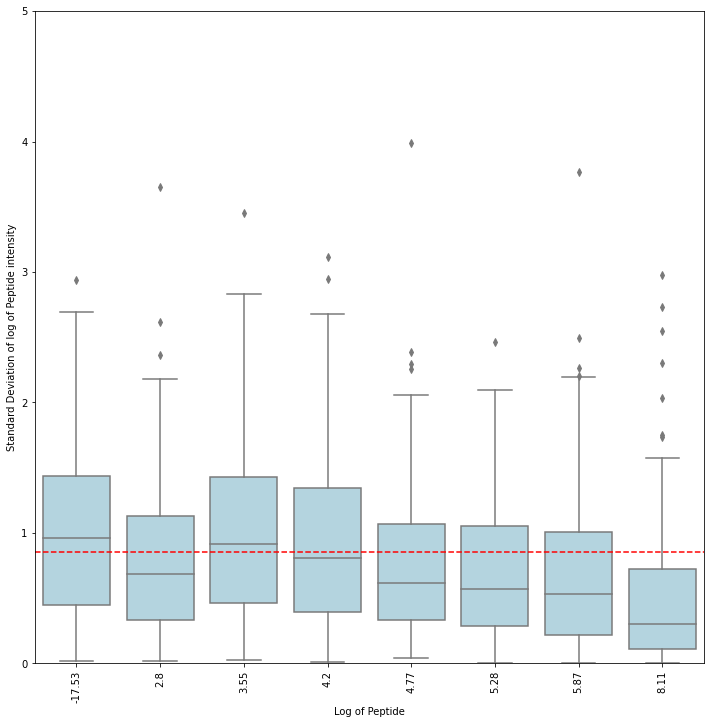

In [15]:
#df = read_in_osw(file_directory, m_score_threshold = 0.01, log = True)
file_directory = '/hdd_14T/data/PXD002952/20210614_dataset/result_files_20220214/DID/osw_results/'
m_score_threshold = 0.01
log = True
quantiles = 8
ylim = [0,5]
hline_type = "mean"

df = read_in_osw(file_directory, m_score_threshold = m_score_threshold, log = log)
df_stats = get_peptide_mu_sigma(df, quantiles = quantiles).dropna()
plot_boxplot(df_stats, log_labels = log, ylim = ylim, hline = hline_type)

# DIANN

In [10]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/result_files_20220214/PS")

/home/ptruong/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ptruong/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


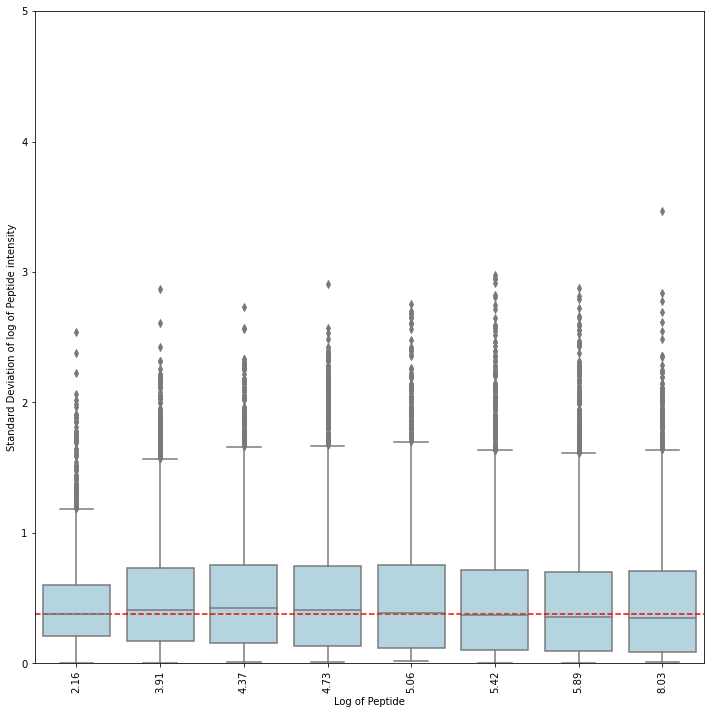

In [11]:
file_name = "report_for_top3.tsv"
q_value_threshold = 0.01
log = True
quantiles = 8

df  = read_in_diann(file = file_name, q_value_threshold = 0.01, log = log)
df_stats = get_peptide_mu_sigma(df, quantiles = quantiles).dropna()
plot_boxplot(df_stats, log_labels = log, ylim = ylim, hline = hline_type)